In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set styles of plots
sns.set(style="whitegrid")

In [2]:
# load training set and test set
train_data = pd.read_csv('option_train.csv')
test_data = pd.read_csv('option_test_wolabel.csv')

In [3]:
# print the number of records in the training set
len(train_data)

1680

# Part I Data preprocessing

## Data cleaning - filling missing values

In [4]:
# check missing value
print("Training Data Missing Values Statistics:")
print(train_data.isnull().sum())

# use median imputation for numerical variables
numeric_features = ['Value', 'S', 'K', 'tau', 'r']
for feature in numeric_features:
    median_value = train_data[feature].median()
    train_data[feature].fillna(median_value, inplace=True)

# use mode imputation for categorical variables
categorical_features = ['BS']
for feature in categorical_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature].fillna(mode_value, inplace=True)

# confirm that missing values have been handled
print("\nAfter handling missing values, training data missing values statistics:")
print(train_data.isnull().sum())

# apply the same processing to the test set
print("\nTest Data Missing Values Statistics:")
print(test_data.isnull().sum())

for feature in ['S', 'K', 'tau', 'r']:
    median_value = train_data[feature].median()
    test_data[feature].fillna(median_value, inplace=True)

print("\nAfter handling missing values, test data missing values statistics:")
print(test_data.isnull().sum())

Training Data Missing Values Statistics:
Value    1
S        1
K        2
tau      1
r        0
BS       0
dtype: int64

After handling missing values, training data missing values statistics:
Value    0
S        0
K        0
tau      0
r        0
BS       0
dtype: int64

Test Data Missing Values Statistics:
S      0
K      0
tau    0
r      0
dtype: int64

After handling missing values, test data missing values statistics:
S      0
K      0
tau    0
r      0
dtype: int64


We fill missing values with median.

## Data cleaning - remove erroneous entries

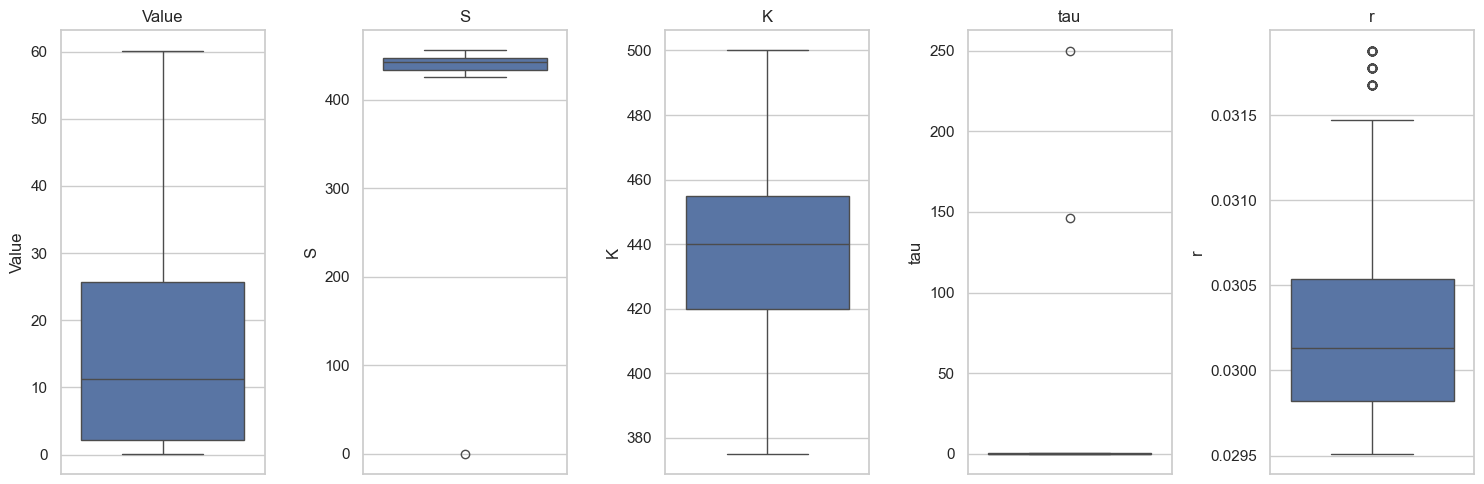

In [5]:
# box plot to visualize erroneous entries
numeric_features = ['Value', 'S', 'K', 'tau', 'r']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numeric_features):
    plt.subplot(1, len(numeric_features), i+1)
    sns.boxplot(y=train_data[feature])
    plt.title(feature)
plt.tight_layout()
plt.savefig("figure/Data cleaning - boxplot.png")
plt.show()

Erroneous entries in this boxplot are data points that are significantly distant from the majority of the data. For example, predictor **S** has one erroneous entry, predictor **tau** has two. Predictor **r** also has some outliers. These may be caused by the right-skewed distribution of the data. We remove the erroneous entries in we see from S and tau, and keep the outliers we see in r.

In [6]:
# remove the erroneous entries
train_data_clean = train_data.copy()

# create a dictionary to record the erroneous entries
outliers_count = {}

for feature in numeric_features:
    Q1 = train_data[feature].quantile(0.25)
    Q3 = train_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR

    # count the number of erroneous entries
    outliers = ((train_data[feature] < lower_bound) | (train_data[feature] > upper_bound))
    outliers_count[feature] = outliers.sum()
    
    # data without erroneous entries
    train_data_clean = train_data_clean[(train_data_clean[feature] >= lower_bound) & (train_data_clean[feature] <= upper_bound)]

# print number of erroneous entries for each feature
for feature, count in outliers_count.items():
    print(f"{feature}: {count} erroneous entries")
train_data = train_data_clean

Value: 0 erroneous entries
S: 1 erroneous entries
K: 0 erroneous entries
tau: 2 erroneous entries
r: 0 erroneous entries


In [7]:
# number of records remaining in training set
len(train_data)

1677

3 data points are removed.

## Data transformation - z-score normalization

In [8]:
# create a StandardScaler
scaler = StandardScaler()

# standardize all numerical columns in train_data
train_data_scaled = train_data.copy()
train_data_scaled[['S', 'K', 'tau', 'r']] = scaler.fit_transform(train_data_scaled[['S', 'K', 'tau', 'r']])

train_data = train_data_scaled

Data normalization. Z-score normalization. Rescale the data of each numeric predictor to have a mean of 0 and a standard deviation of 1.

We can see that the ranges of values of different predictors - S, K, tau, r, vary greatly. For example, the range of K is very wide, ranging from about 380 to 500. However, the range of r is very narrow, with a width of less than 0.01.

## Data transformation - transform categorical variable into dummy variable

In [9]:
train_data['BS_label'] = train_data['BS'].map({'Over': 1, 'Under': 0})

# Part II Exploratory Data Analysis (EDA)

## Graphical summary of numerical variable

In [10]:
# calculate the class distribution of the BS column
bs_counts = train_data['BS'].value_counts()
bs_summary = pd.DataFrame({
    'Category': bs_counts.index,
    'Count': bs_counts.values,
    'Percentage': (bs_counts / bs_counts.sum()) * 100
})

bs_summary

,Category,Count,Percentage
BS,,,
Under,Under,946,56.410256
Over,Over,731,43.589744


## Numerical summary of numerical variables

In [11]:
# statistics of numerical variables
numerical_summary = train_data[['Value', 'S', 'K', 'tau', 'r']].describe()
numerical_summary = numerical_summary.applymap(lambda x: f"{x:.2f}")
numerical_summary

,Value,S,K,tau,r
count,1677.00,1677.00,1677.00,1677.00,1677.00
mean,15.09,0.00,-0.00,-0.00,0.00
std,14.04,1.00,1.00,1.00,1.00
min,0.13,-2.05,-2.70,-1.98,-1.30
25%,2.26,-0.93,-0.78,-0.83,-0.74
50%,11.25,0.22,0.08,0.00,-0.19
75%,25.75,0.85,0.72,0.84,0.55
max,60.15,1.99,2.64,1.91,2.95


## Graphical summary of numerical variables

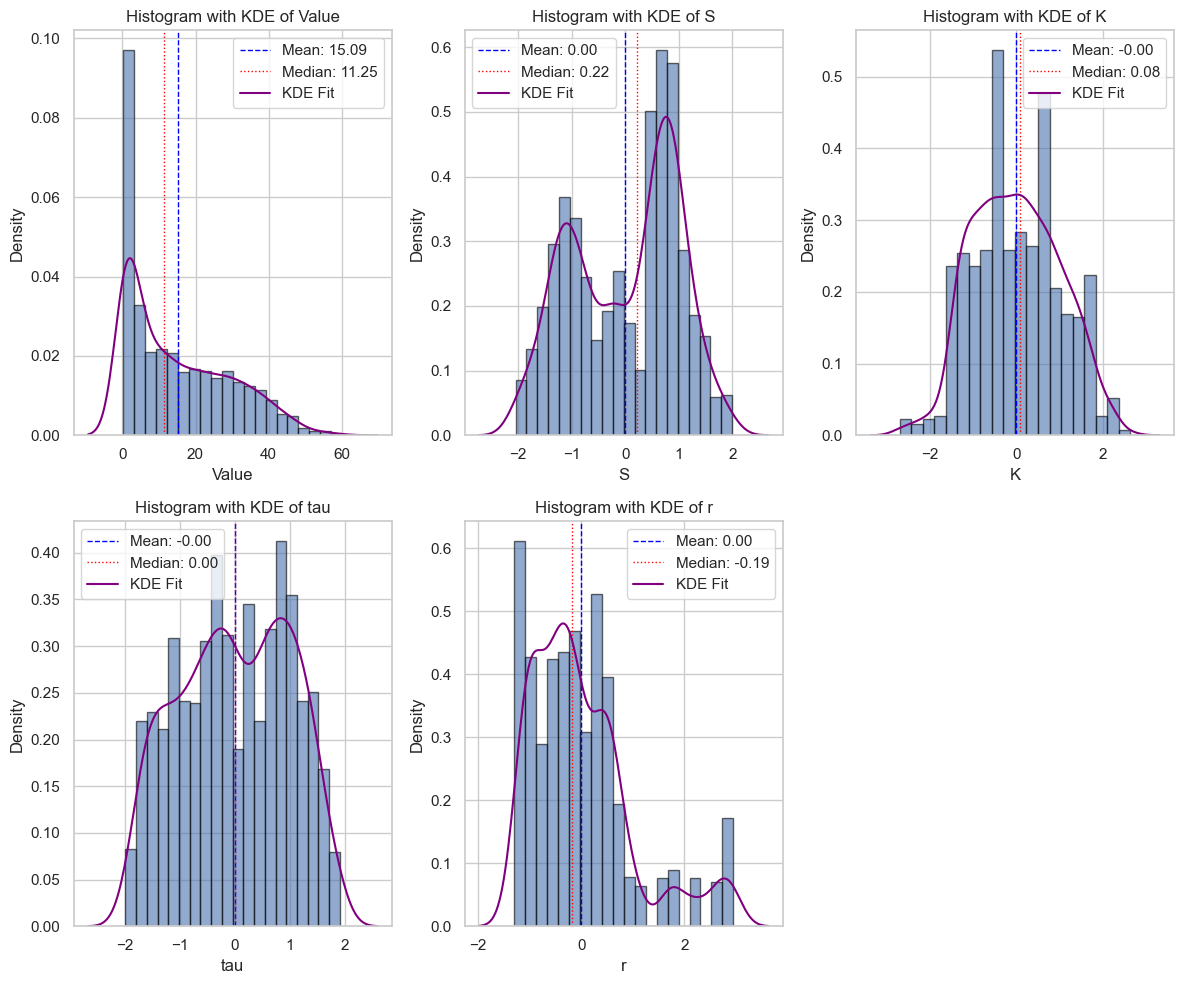

In [12]:
# histogram and kde of numerical variables

variables = ['Value', 'S', 'K', 'tau', 'r']

# set figure size
plt.figure(figsize=(12, 10))

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    data = train_data[var]
    
    # plot histogram
    plt.hist(data, bins=20, edgecolor='black', alpha=0.6, density=True)
    
    # calculate mean and median
    mean_val = np.mean(data)
    median_val = np.median(data)
    
    # plot vertical lines for the mean and median
    plt.axvline(mean_val, color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='red', linestyle='dotted', linewidth=1, label=f'Median: {median_val:.2f}')
    
    # fit KDE
    sns.kdeplot(data, color='purple', linewidth=1.5, label='KDE Fit')
    
    # add title and labels
    plt.title(f'Histogram with KDE of {var}')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend()

plt.savefig("figure/Numerical variables - histogram.png")
plt.tight_layout()
plt.show()

Value: Distribution is positively skewed (right-skewed), with most data concentrated on the lower end and a long tail extending towards higher values.

S: Distribution appears bimodal, indicating two distinct peaks. The values are spread across the range, with the central region being more populated.

K: Distribution is approximately symmetric and centered around zero, resembling a normal distribution.

tau: Distribution appears approximately symmetric with slight multimodal tendencies. The values are centered around zero.

r: Distribution shows slight asymmetry and may have a multimodal structure. There is a slight shift to the left of zero.

## Relationship between variables

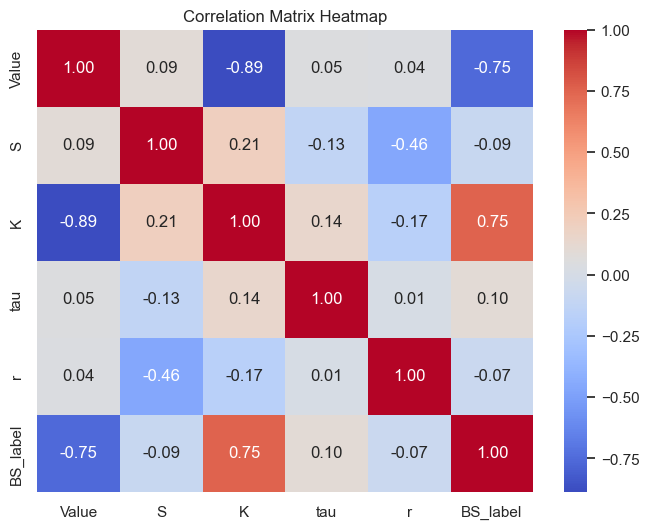

In [13]:
# heatmap of correlation matrix
columns_of_interest = ['Value', 'S', 'K', 'tau', 'r', 'BS_label']
correlation_matrix = train_data[columns_of_interest].corr()

# plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Heatmap")

# save the figure
file_path = 'figure/correlation_matrix_heatmap.png'
plt.savefig(file_path)
plt.show()

-0.89: There is a strong linear correlation between predictor K and response Value.
This is consistent with the logic of the options market: for a call option, a higher strike price (K) may mean that a larger increase in the price of the underlying asset is required to make a profit, resulting in a lower option value (C).

0.75: Also there is a strong linear correlation between predictor K and response BS_label.

Model choice: explore potential nonlinear relationship. We can try some nonlinear models.

Nonlinear regression models.
- Polynomial regression, gradient boosting, SVR, neural network, etc.

Nonlinear classification models.
- Decision Tree, random forest, SVM, neural network, etc.

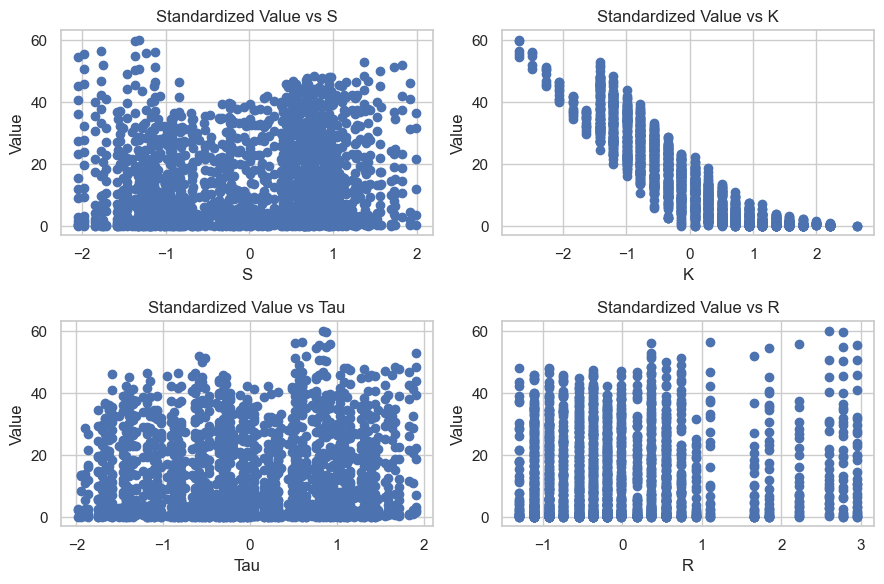

In [14]:
# scatterplot: Value v.s. predictors
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

axs[0, 0].scatter(train_data['S'], train_data['Value'])
axs[0, 0].set_title('Standardized Value vs S')
axs[0, 0].set_xlabel('S')
axs[0, 0].set_ylabel('Value')

axs[0, 1].scatter(train_data['K'], train_data['Value'])
axs[0, 1].set_title('Standardized Value vs K')
axs[0, 1].set_xlabel('K')
axs[0, 1].set_ylabel('Value')

axs[1, 0].scatter(train_data['tau'], train_data['Value'])
axs[1, 0].set_title('Standardized Value vs Tau')
axs[1, 0].set_xlabel('Tau')
axs[1, 0].set_ylabel('Value')

axs[1, 1].scatter(train_data['r'], train_data['Value'])
axs[1, 1].set_title('Standardized Value vs R')
axs[1, 1].set_xlabel('R')
axs[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.savefig("Figure/Scatterplot - Value vs predictors.png")
plt.show()

The Relationship Between Value and S: The relationship between Value and S in the plot shows a certain pattern but exhibits considerable dispersion. This distribution might be nonlinear, making it suitable for modeling with nonlinear regression techniques, such as Random Forest Regression or Gradient Boosting Regression, to capture the complex relationship.

The Relationship Between Value and K: There is a strong nonlinear relationship between Value and K, characterized by a clear curved trend.
This indicates that simple linear regression may not adequately capture the relationship between K and Value. Recommended models: Polynomial Regression, Random Forest Regression, or Support Vector Regression (SVR) can be used to capture these nonlinear characteristics effectively.

The Relationship Between Value and Tau: The scatter plot between Tau and Value shows a relatively dispersed distribution, with no clear linear or nonlinear trend. This may indicate that Tau has a low predictive contribution to Value. If further analysis confirms a low correlation, it might be worth considering the removal of this feature during modeling.

The Relationship Between Value and R: The scatter plot between R and Value appears relatively uniform, potentially indicating an implicit nonlinear relationship. Recommended models: Techniques like Random Forest Regression or Gradient Boosting Regression are better suited to handle such potentially complex relationships.

**Summary and Recommended Regression Models**  
Based on the observations above, the following types of regression models are recommended:  

- **Random Forest Regression**:  
  - Capable of capturing complex nonlinear relationships.  
  - Provides interpretability by ranking feature importance.  

- **Gradient Boosting Regression (e.g., XGBoost, LightGBM, CatBoost)**:  
  - Allows fine-tuning of the model for better performance.  
  - Highly robust against noise in the data.  

- **Support Vector Regression (SVR)**:  
  - Suitable for smaller datasets, where kernel functions (e.g., RBF) can effectively model nonlinear relationships.  

- **Polynomial Regression (for the relationship with K)**:  
  - Can be attempted to capture the nonlinear pattern between K and Value.  

- **Neural Networks**:  
  - As a powerful nonlinear model, neural networks are highly suitable for predicting complex relationships between Value and other variables (S, K, Tau, R).  

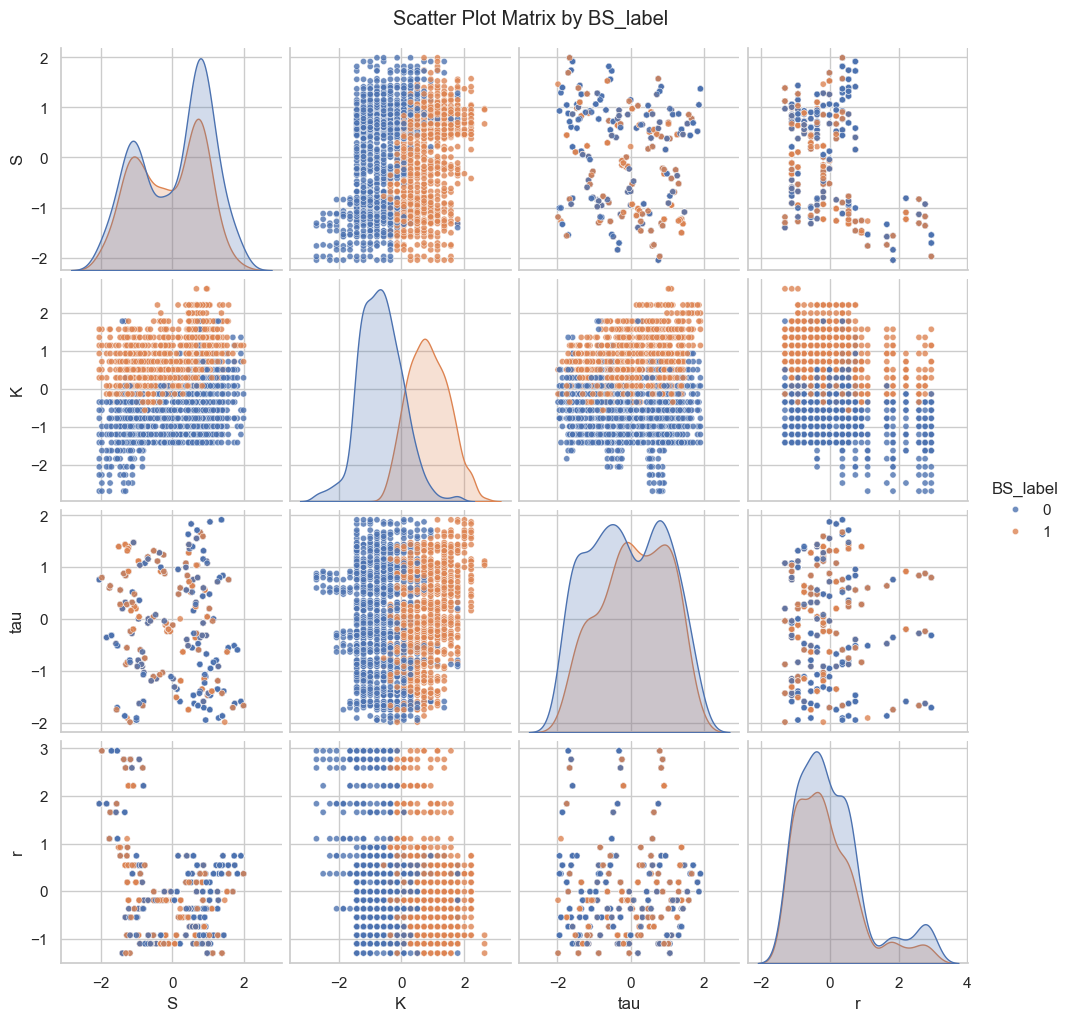

In [15]:
# scatterplot matrix by BS_label
# define predictors and reponse
features = ['S', 'K', 'tau', 'r']
target = 'BS_label'

# draw pairplot
pairplot = sns.pairplot(
    train_data[features + [target]],  
    hue=target,  
    height=2.5,  
    plot_kws={'s': 20, 'alpha': 0.8},  
    diag_kind='kde'  
)

# set titles
plt.suptitle("Scatter Plot Matrix by BS_label", y=1.02) 

# save the figure
output_file = "figure/scatter_plot_matrix_by_BS_label.png"  
pairplot.fig.savefig(output_file)  

plt.show()

From the KDE plots on the diagonal, we can see that the two categories of K show a relatively significant difference in their distributions. Therefore, K is likely to provide substantial information when predicting the target variable, BS_label.

According to scatter plots. 1) The predictors do not exhibit an obvious correlation. 2) In the scatter plots of certain feature pairs, BS_label 0 and 1 show a clear separation trend, such as K and tau, and K and r. 

However, this phenomenon is likely primarily driven by K. We can conduct a simple logistic regression to verify this. First, using only K to predict BS gives an AUC value of 0.9484. Then, using both K and r to predict BS only increases the AUC value slightly to 0.9487.

In [16]:
X_1 = train_data[['K']]
X_2 = train_data[['K', 'r']]
y = train_data['BS_label']

# cross validation
clf = LogisticRegression(random_state=42)
scores_original = cross_val_score(clf, X_1, y, cv=5, scoring='roc_auc')
scores_combined = cross_val_score(clf, X_2, y, cv=5, scoring='roc_auc')

print(f'Original AUC: {scores_original.mean():.4f}')
print(f'AUC with feature added: {scores_combined.mean():.4f}')

Original AUC: 0.9484
AUC with feature added: 0.9487
